# Periodic Boundaries & Neighbor Lists for Bulk LJ 

The aim of this is to stimulate bulk fluid from finite boxes 

- Implement **periodic boundary conditions (PBC)**
- Use the **minimum image convention** for distance and forces 
- Speed up force evaluation with **Vervet neighbor lists** --> Skin and periodic rebuild 
- Check energy stability and compute the **radial distribution function** g(r). 

Bulk initialization -> PBC + MIC -> Neighbor lists -> Measurements (E, g(r)) 


- Cubic PBC in all directions; MIC for all pair distances. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Lennard-Jones fluid simulation with periodic boundary conditions (PBC) and minimum image convention (MIC) -- in reduced units 
# Potential energy 
def U_LJ(r):
    invr6 = (1.0 / r) ** 6
    return 4.0 * (invr6 ** 2 - invr6)   

def F_LJ_over_r(r):  # Force 
    # return F(r)/r
    invr2 = (1.0 / r) ** 2
    invr6 = invr2 ** 3
    # 
    return 24.0 * (2.0 * invr6 ** 2 - invr6) * (1.0 / r)


def wrap_positions(pos, L): # PBC postion and length of the box
    return pos - L * np.floor(pos / L)

def minimum_image(vec, L):
    # apply MIC to displacement vector (s), MIC ensures that the shortest image (the “minimum image”) is used., use nearest image for interactions 
    return vec - L * np.round(vec / L)


## Bulk Initialization

In [24]:
rho = 0.8  # density
Ngrid = 6
N = Ngrid ** 3  # number of particles
L = (N / rho) ** (1.0 / 3.0)

# PLace particles on SC grid 
a = L / Ngrid  # lattice constant
coords = np.linspace(0.5 * a, L - 0.5 * a, Ngrid)
x, y, z = np.meshgrid(coords, coords, coords, indexing='ij')
positions = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
np.random.seed(2)
positions += 0.05*a * (np.random.rand(N, 3) - 0.5)  # small random displacements
positions = wrap_positions(positions, L)    

# initial velocities 
velocities = np.random.randn(N, 3)
velocities -= velocities.mean(axis=0)  # zero net momentum

dt = 0.002
rc = 2.5
rskin = 0.3 
rlist = rc + rskin

## Verlet neighbor list 

In [25]:
def build_neighbor_list(positions, L, rc_list):
    N = positions.shape[0]
    nlist = [[] for _ in range(N)]
    for i in range(N-1):
            rij = positions[i+1:] - positions[i]
            rij = minimum_image(rij, L)
            dist2 = np.sum(rij**2, axis=1)
            mask = dist2 < rc_list**2
            js = np.nonzero(mask)[0] + (i + 1)
            for j in js:
                nlist[i].append(j)
    return nlist

neighbor_list = build_neighbor_list(positions, L, rlist)
ref_positions = positions.copy()

## Forces with MIC and neighbour list 

In [26]:
def compute_forces_verlet(positions, L, rc, nlist):
    N = positions.shape[0]
    forces = np.zeros_like(positions)
    pot = 0.0 
    
    for i in range(N-1): 
        for j in nlist[i]:
            rij = positions[i] - positions[j]
            rij = minimum_image(rij, L)
            r = np.linalg.norm(rij)
            if r < rc:
                fij_over_r = F_LJ_over_r(r)
                fij = fij_over_r * rij 
                forces[i] += fij
                forces[j] -= fij  # Newton's third law
                pot += U_LJ(r)
    return forces, pot

## Integration (Velocity Verlet) with neighbour rebuild 

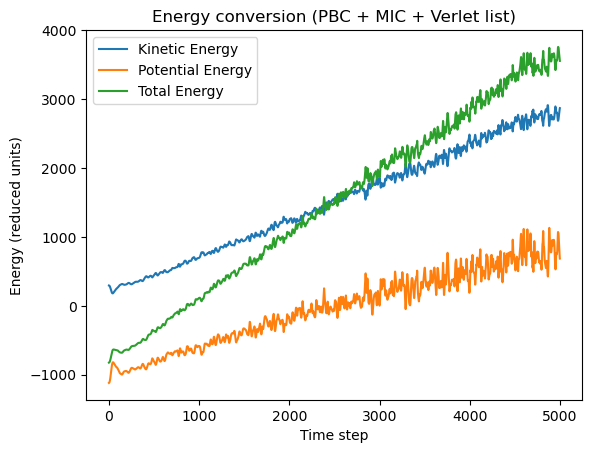

In [27]:
def max_displacement(p, p_ref, L):
    disp = minimum_image(p - p_ref, L)
    return np.max(np.linalg.norm(disp, axis=1))

save_stride = 20
traj =[]
KE, PE, TE = [], [], []

forces , pot = compute_forces_verlet(positions, L, rc, neighbor_list)

steps = 5000 
for step in range(steps):
    # Update velocities, half-kick 
    velocities += 0.5 * forces * dt
    
    # drift / position update
    positions += velocities * dt 
    positions = wrap_positions(positions, L)  # PBC

    # Check if we need to rebuild the neighbor list
    if max_displacement(positions, ref_positions, L) > 0.5 * rskin:
        neighbor_list = build_neighbor_list(positions, L, rlist)
        ref_positions = positions.copy()
        
    # Compute new forces
    forces_new, pot = compute_forces_verlet(positions, L, rc, neighbor_list)
    velocities += 0.5 * forces_new * dt  # second half-kick
    
    kin = 0.5 * np.sum(velocities**2)
    KE.append(kin)
    PE.append(pot)
    TE.append(kin + pot)
    
    if step % save_stride == 0:
        traj.append(positions.copy())
        
        
#plot energies
plt.plot(KE, label='Kinetic Energy')
plt.plot(PE, label='Potential Energy')
plt.plot(TE, label='Total Energy')
plt.xlabel('Time step')
plt.ylabel('Energy (reduced units)')
plt.title('Energy conversion (PBC + MIC + Verlet list)')
plt.legend()
plt.show()